### Questo file ha il compito di generare una tabella contenente tutti gli attributi utili dei tre file, vanno inoltre settatati a missing value tutti gli attributi semanticamente scorretti (eccezzione fatta per i campi notes e incident characteristic1), vanno fatti controlli sulla consistenza dei dati tra i diversi attributi, nello stesso recors ed infine tolti i record sopra una percentuale di valori null.

In [1]:
DATA_PATH = '../../data' #Insert path to data here

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

incidents_dtype={
    'state': 'string',
    'city_or_county': 'string',
    'address': 'string',
    'latitude': 'float64',
    'longitude': 'float64',
    'congressional_district': 'Int64',
    'state_house_district': 'Int64',
    'state_senate_district': 'Int64',
    'participant_age1': 'Int64',
    'participant_age_group1': 'string',
    'participant_gender1': 'string',
    'n_males': 'float64',
    'n_females': 'float64',
    'n_killed': 'int64',
    'n_injured': 'int64',
    'n_arrested': 'float64',
    'n_unharmed': 'float64',
    'n_participants': 'float64',
    'n_arrested': 'float64',
    'notes': 'string',
    'incident_characteristics1': 'string',
    'incident_characteristics2': 'string'}

poverty_dtype={
            'state': 'string',
            'year': 'int64',
            'povertyPercentage': 'float64'
    }

state_dtype={
        'year': 'Int64',
        'state': 'string',
        'congressional_district': 'Int64',
        'party': 'string',
        'candidatevotes': 'Int64',
        'totalvotes': 'Int64'
    }
    
tab1= pd.read_csv(f"{DATA_PATH}/incidents.csv",low_memory=False)
tab3 = pd.read_csv(f"{DATA_PATH}/year_state_district_house.csv",low_memory = False)

In [3]:
nullCount_beforeProcessing = tab1.isnull().sum()

Filliamo tutti i campi null di incidents_characteristic1 e notes con stringhe "NULL"

In [4]:
# tab1["notes"]=tab1["notes"].replace(to_replace=np.nan,value="NULL")
# tab1["incident_characteristics1"]=tab1["incident_characteristics1"].replace(to_replace=np.nan,value="NULL")

# Cleaning incidents data

### Cleaning dati sintaticamente errati

In [5]:
tab1['date'] = pd.to_datetime(tab1['date'], format='%Y-%m-%d')
#Eliminazione dati con tipo string e conversione in float64
tab1['min_age_participants'] = pd.to_numeric(tab1['min_age_participants'], errors='coerce')
tab1['avg_age_participants'] = pd.to_numeric(tab1['avg_age_participants'], errors='coerce')
tab1['max_age_participants'] = pd.to_numeric(tab1['max_age_participants'], errors='coerce')
tab1['n_participants_child'] = pd.to_numeric(tab1['n_participants_child'], errors='coerce')
tab1['n_participants_teen'] = pd.to_numeric(tab1['n_participants_teen'], errors='coerce')
tab1['n_participants_adult'] = pd.to_numeric(tab1['n_participants_adult'], errors='coerce')

### Cleaning dati semanticamenti erratti (e.g. valori negativi per l'età, inconsistenza tra gli attributi, etc.)
In questa fase vengono posti a null tutti gli attributi semanticamenti scorretti per due motivi
- In generale i dati interessati dalle seguente regole logiche sono una piccola percentuale del dataset
- Se una entry presenta dati inconsistenti tra di loro, è impossibile determinare quale attributo è corretto e quale incorretto. Per questo motivo, vengono posti a NULL tutti gli attributi che generano l'inconsistenza

### Rimozione duplicati
Come possiamo osservare dalla seguente cella, nel dataset sono presenti una serie di valori duplicati. Possiamo ipotizzare che uno stesso incidente è stato inserito più volte nella tabella dato che è altamente improbabile che due incidenti differenti abbiano 28 attributi uguali (considerando il fatto che questi attributi hanno diversi campi string che devono essere riempiti manualmente)

In [6]:
before = tab1.shape
tab1.drop_duplicates(inplace=True)
after = tab1.shape

print("Prima della rimozione: ", before)
print("Dopo la rimozione: ", after)
print("Lost rows: ", (before[0]-after[0])/before[0]*100, "%")

Prima della rimozione:  (239677, 28)
Dopo la rimozione:  (239381, 28)
Lost rows:  0.12349954313513604 %


#### Cleaning dati numerici negativi o con un valore estremamente elevato

In [7]:
tab1.loc[(tab1['min_age_participants'] < 0) | (tab1['min_age_participants'] > 122), 'min_age_participants'] = np.nan
tab1.loc[(tab1['max_age_participants'] < 0) | (tab1['max_age_participants'] > 122), 'max_age_participants'] = np.nan
tab1.loc[(tab1['avg_age_participants'] < 0) | (tab1['avg_age_participants'] > 122), 'avg_age_participants'] = np.nan
tab1.loc[(tab1['participant_age1'] < 0) | (tab1['participant_age1'] > 122), 'participant_age1'] = np.nan

cols = ['n_participants_adult', 'n_participants_child', 'n_participants_teen', 'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants']
for col in cols:
    tab1.loc[(tab1[col] < 0) | (tab1[col] > 103), col] = np.nan

#### Cleaning attributo date
I dati sono stati eliminati secondo le considerazione fatte qui: https://www.notion.so/Analisi-singoli-attributi-b4a8e54b160f4e84a7f9751673423b39?pvs=4#9144d4dcc0ba46d6ae0bff18e8dac422
- Per ora poniamo il campo date a null nei periodi sbagliati; saranno le regole logiche stabilite di seguito a determinare anche se gli altri campi sono sbagliati

In [8]:
tab1.loc[tab1['date'].dt.year.isin([2013,2028, 2029, 2030]), 'date'] = np.nan

#### Cleaning sugli attributi incosistenti tra di loro
Un'analisi dettagliata dell'effetto di queste regole logiche si può osservare nel file ../data_understanding/CleaningEffect.ipynb

In [9]:

# min_age_participants < 12 <=> n_participants_child > 0
mask = (tab1['min_age_participants'] < 12) & (tab1['n_participants_child'] == 0)
tab1.loc[mask, ['n_participants_child', 'min_age_participants']] = np.nan

# max_age_participants ≥ 18 <=> n_participants_adult > 0
mask = (tab1['max_age_participants'] >= 18) & (tab1['n_participants_adult'] == 0)
tab1.loc[mask, ['n_participants_adult', 'max_age_participants']] = np.nan

# max_age_participants < 18 <=> [(n_participants_teen > 0 || n_participants_child > 0) && n_participants_adult = 0]
mask1 = (tab1['max_age_participants'] < 18)
mask2 = (tab1['n_participants_teen'] == 0) | (tab1['n_participants_child'] == 0)
mask3 = (tab1['n_participants_adult'] != 0)
final_mask = mask1 & mask2 & mask3
tab1.loc[final_mask, ['max_age_participants', 'n_participants_teen', 'n_participants_child', 'n_participants_adult']] = np.nan

# n_participants_child = n_participants => min_age_participants ≤ 11
mask1 = tab1['n_participants_child'] == tab1['n_participants']
mask2 = tab1['min_age_participants'] > 11
final_mask = mask1 & mask2
tab1.loc[final_mask, ['n_participants_child', 'n_participants', 'avg_age_participants', 'max_age_participants', 'min_age_participants']] = np.nan

# n_participants_teen = n_participants => 12 <= min_age_participants ≤ 17
mask1 = tab1['n_participants_teen'] == tab1['n_participants']
mask2 = (tab1['min_age_participants'] < 12) | (tab1['min_age_participants'] > 17)
final_mask = mask1 & mask2
tab1.loc[final_mask, ['n_participants_teen', 'n_participants', 'min_age_participants']] = np.nan

# n_participants_adult = n_participants_adult => min_age_participants >= 18
mask1 = tab1['n_participants_adult'] == tab1['n_participants']
mask2 = tab1['min_age_participants'] < 18
final_mask = mask1 & mask2
tab1.loc[final_mask, ['n_participants_adult', 'n_participants', 'min_age_participants']] = np.nan

# n_participants == n_participants_teen ⇒ 12 < participant_age1 ≤ 17
mask1 = tab1['n_participants'] == tab1['n_participants_teen']
mask2 = (tab1['participant_age1'] < 12) | (tab1['participant_age1'] > 17)
final_mask = mask1 & mask2
tab1.loc[final_mask, ['n_participants', 'n_participants_teen', 'participant_age1']] = np.nan

# n_participants == n_participants_adult ⇒ participant_age1 >= 18
mask1 = tab1['n_participants'] == tab1['n_participants_adult']
mask2 = tab1['participant_age1'] < 18
final_mask = mask1 & mask2
inconsistent_entry = tab1.loc[final_mask, ['n_participants', 'n_participants_adult', 'participant_age1']]

# df.n_participants == df.n_participants_adult ⇒ participant_age1 >= 18
mask1 = tab1['n_participants'] == tab1['n_participants_adult']
mask2 = tab1['participant_age1'] < 18
final_mask = mask1 & mask2
inconsistent_entry = tab1.loc[final_mask, ['n_participants', 'n_participants_adult', 'participant_age1']]
tab1.loc[final_mask, ['n_participants', 'n_participants_adult', 'participant_age1']] = np.nan

# n_participants_teen + n_participants_adult + n_participants_child = n_participants
mask0 = tab1['n_participants_teen'].notnull() & tab1['n_participants_adult'].notnull() & tab1['n_participants_child'].notnull() & tab1['n_participants'].notnull()
mask1 = tab1['n_participants_teen'] + tab1['n_participants_adult'] + tab1['n_participants_child'] != tab1['n_participants']
final_mask = mask0 & mask1
tab1.loc[final_mask, ['n_participants_teen', 'n_participants_adult', 'n_participants_child', 'n_participants']] = np.nan

#  12 ≤ participant_age1 < 18  & n_participants1 = 1 ⇒ participant_age_group1==teen
mask1 = (tab1['participant_age1'] >= 12) & (tab1['participant_age1'] < 18)
mask2 = (tab1['n_participants'] == 1)
mask3 = (tab1['participant_age_group1'] != 'Teen 12-17')
final_mask = mask1 & mask2 & mask3
tab1.loc[final_mask, ['participant_age1', 'participant_age_group1']] = np.nan

# n_males + n_females = n_participants
mask0 = tab1['n_participants'].notnull() & tab1['n_males'].notnull() & tab1['n_females'].notnull()
mask1 = tab1['n_males'] + tab1['n_females'] != tab1['n_participants']
final_mask = mask0 & mask1
tab1.loc[final_mask, ['n_males', 'n_females', 'n_participants']] = np.nan

### Distribuzione valori null

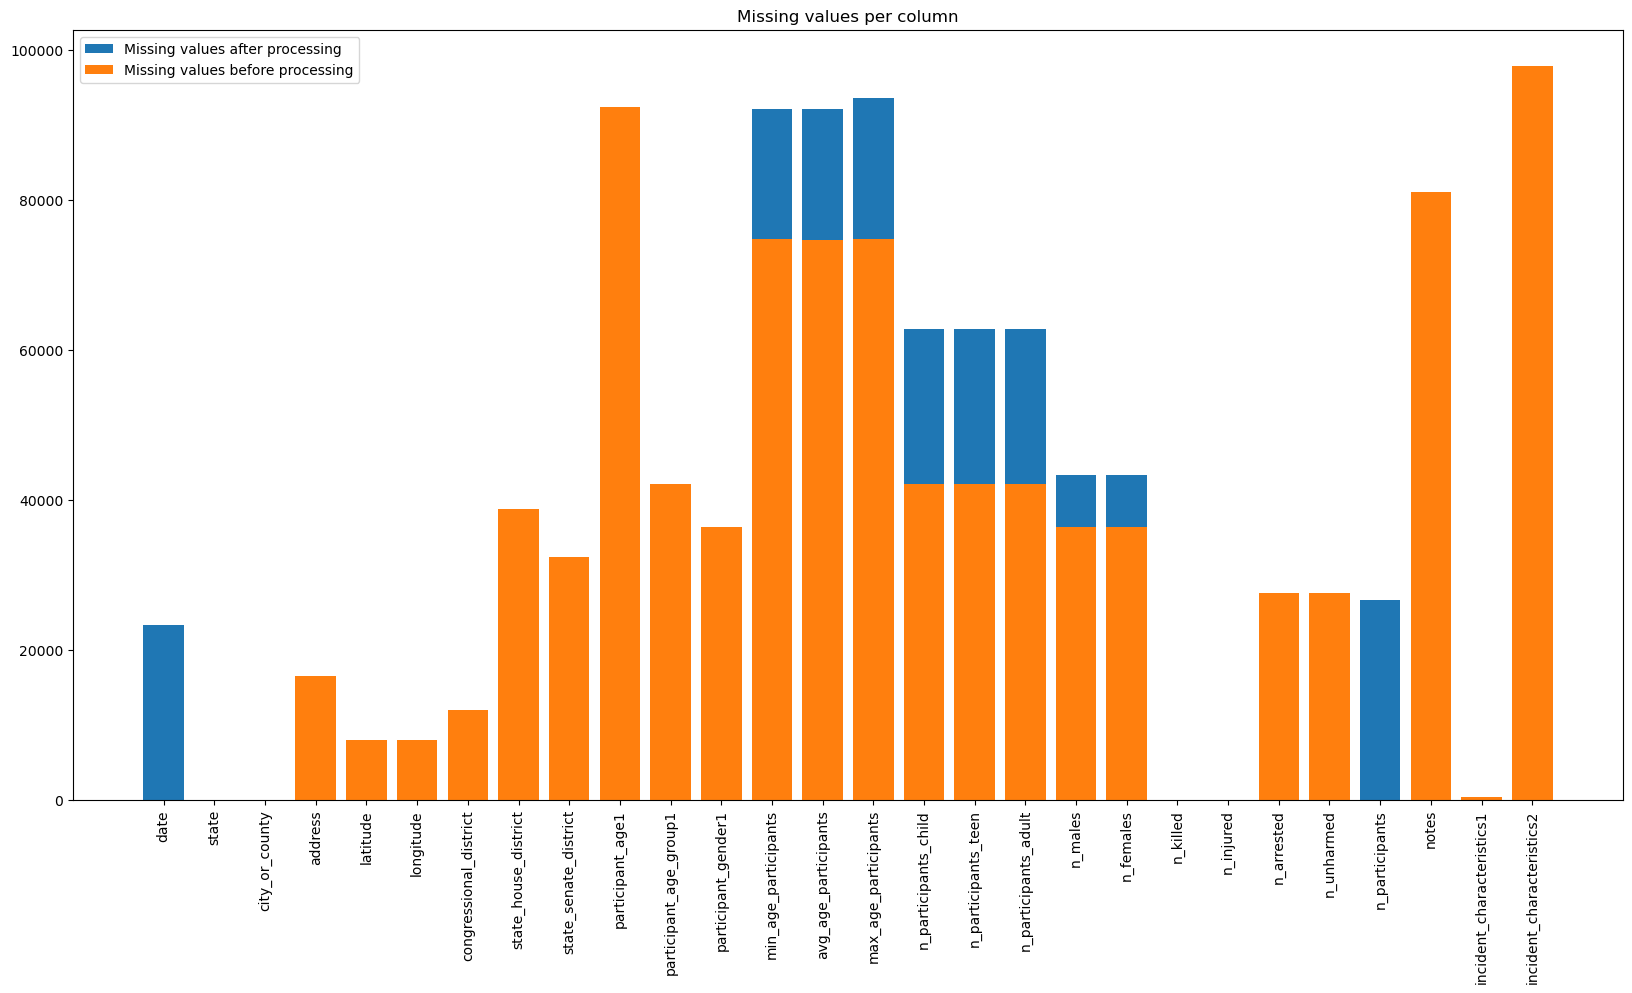

In [10]:
cleaningTab1 = tab1.isnull().sum()
plt.figure(figsize=(20,10))
plt.bar(tab1.columns, cleaningTab1, label='Missing values after processing')
plt.bar(tab1.columns, nullCount_beforeProcessing, label='Missing values before processing')
plt.title('Missing values per column')
plt.legend()
plt.xticks(rotation=90)
plt.show()

### Stima valori NULL dei dati tra i diversi attributi in incidents

In [11]:
#n_participants1 = 1 ⇒ min_age_participants == avg_age_participants == max_age_participants
#da quanto fatto precedentemente sappiamo che non ci sono entry con n_part == 1 con valori inconsistenti
#si può gestire il caso in cui almeno una delle tre  o due, siano dello stesso valore, per settare le rimanenti a quel valore
mask = (tab1["n_participants"]== 1) & (tab1["max_age_participants"].notnull())
# si usa mask negata in and col resto, per evitare di ripetere le assegnazioni dove sono già state fatte tramite mask
mask2 = (~mask) & (tab1["n_participants"]== 1)& (tab1["min_age_participants"].notnull())
mask3 = (~mask) & (~mask2) & (tab1["n_participants"]== 1) & (tab1["avg_age_participants"].notnull())
tab1.loc[mask,["min_age_participants","avg_age_participants"]]= tab1.loc[mask,"max_age_participants"]
tab1.loc[mask2,["max_age_participants","avg_age_participants"]]= tab1.loc[mask2,"min_age_participants"]
tab1.loc[mask3,["min_age_participants","max_age_participants"]]= tab1.loc[mask3,"avg_age_participants"]

#min_age_participants < 12 && n_participants_child=null && n_participants == 1 ⇒ n_participants_child=1`
mask= (tab1["min_age_participants"] < 12) & (tab1["n_participants_child"].isnull()) & (tab1["n_participants"] == 1)
tab1.loc[mask,"n_participants_child"]= 1

#min_age_participants ≥18 && n_participants_adult=null && n_participants == 1⇒ n_participants_adult = 1`
mask= (tab1["min_age_participants"] >= 18) & (tab1["n_participants_adult"].isnull()) & (tab1["n_participants"] == 1)
tab1.loc[mask,"n_participants_adult"]= 1

# 12 <= min_age_participants < 18 && n_participants_teen=null && n_participants == 1⇒ n_participants_teen = 1`
mask= (tab1["min_age_participants"] < 18) & (tab1["min_age_participants"] >= 12) & (tab1["n_participants_teen"].isnull()) & (tab1["n_participants"] == 1)
tab1.loc[mask,"n_participants_teen"]= 1

#participant_age_group1 == Child && n_participants_child=null && n_participants =1 => n_participants_child = 1`
mask= (tab1["participant_age_group1"] == "Child") & (tab1["n_participants_child"].isnull()) & (tab1["n_participants"] == 1)
tab1.loc[mask,"n_participants_child"]= 1

#participant_age_group1 == Teen && n_participants_teen = null  && n_participants =1 => n_participants_teen = 1`
mask= (tab1["participant_age_group1"] == "Teen") & (tab1["n_participants_teen"].isnull()) & (tab1["n_participants"] == 1)
tab1.loc[mask,"n_participants_teen"]= 1

#participant_age_group1 == Adult && n_participants_adult = null && n_participants =1 => n_participants_adult = 1`
mask= (tab1["participant_age_group1"] == "Adult") & (tab1["n_participants_adult"].isnull()) & (tab1["n_participants"] == 1)
tab1.loc[mask,"n_participants_adult"]= 1

#n_participants1 = 1 & n_participants_adult = 1& n_participants_teen = null & n_participants_child = null=> n_participants_teen = n_participants_child = 0`
mask= (tab1["n_participants"] == 1) & (tab1["n_participants_adult"] == 1) & \
      (tab1["n_participants_teen"].isnull()) & (tab1["n_participants_child"].isnull())
tab1.loc[mask,["n_participants_child","n_participants_teen"]]= 0

#n_participants1 = 1 & n_participants_teen = 1& n_participants_adult = null & n_participants_child = null=> n_participants_adult = n_participants_child = 0`
mask= (tab1["n_participants"] == 1) & (tab1["n_participants_teen"] == 1) & \
      (tab1["n_participants_adult"].isnull()) & (tab1["n_participants_child"].isnull())
tab1.loc[mask,["n_participants_adult","n_participants_child"]]= 0

#n_participants1 = 1 & n_participants_child = 1 & n_participants_teen = null & n_participants_adult = null=> n_participants_teen = n_participants_adult = 0`
mask= (tab1["n_participants"] == 1) & (tab1["n_participants_child"] == 1) & \
      (tab1["n_participants_adult"].isnull()) & (tab1["n_participants_teen"].isnull())
tab1.loc[mask,["n_participants_adult","n_participants_teen"]]= 0


### Distribuzione valori recuperati

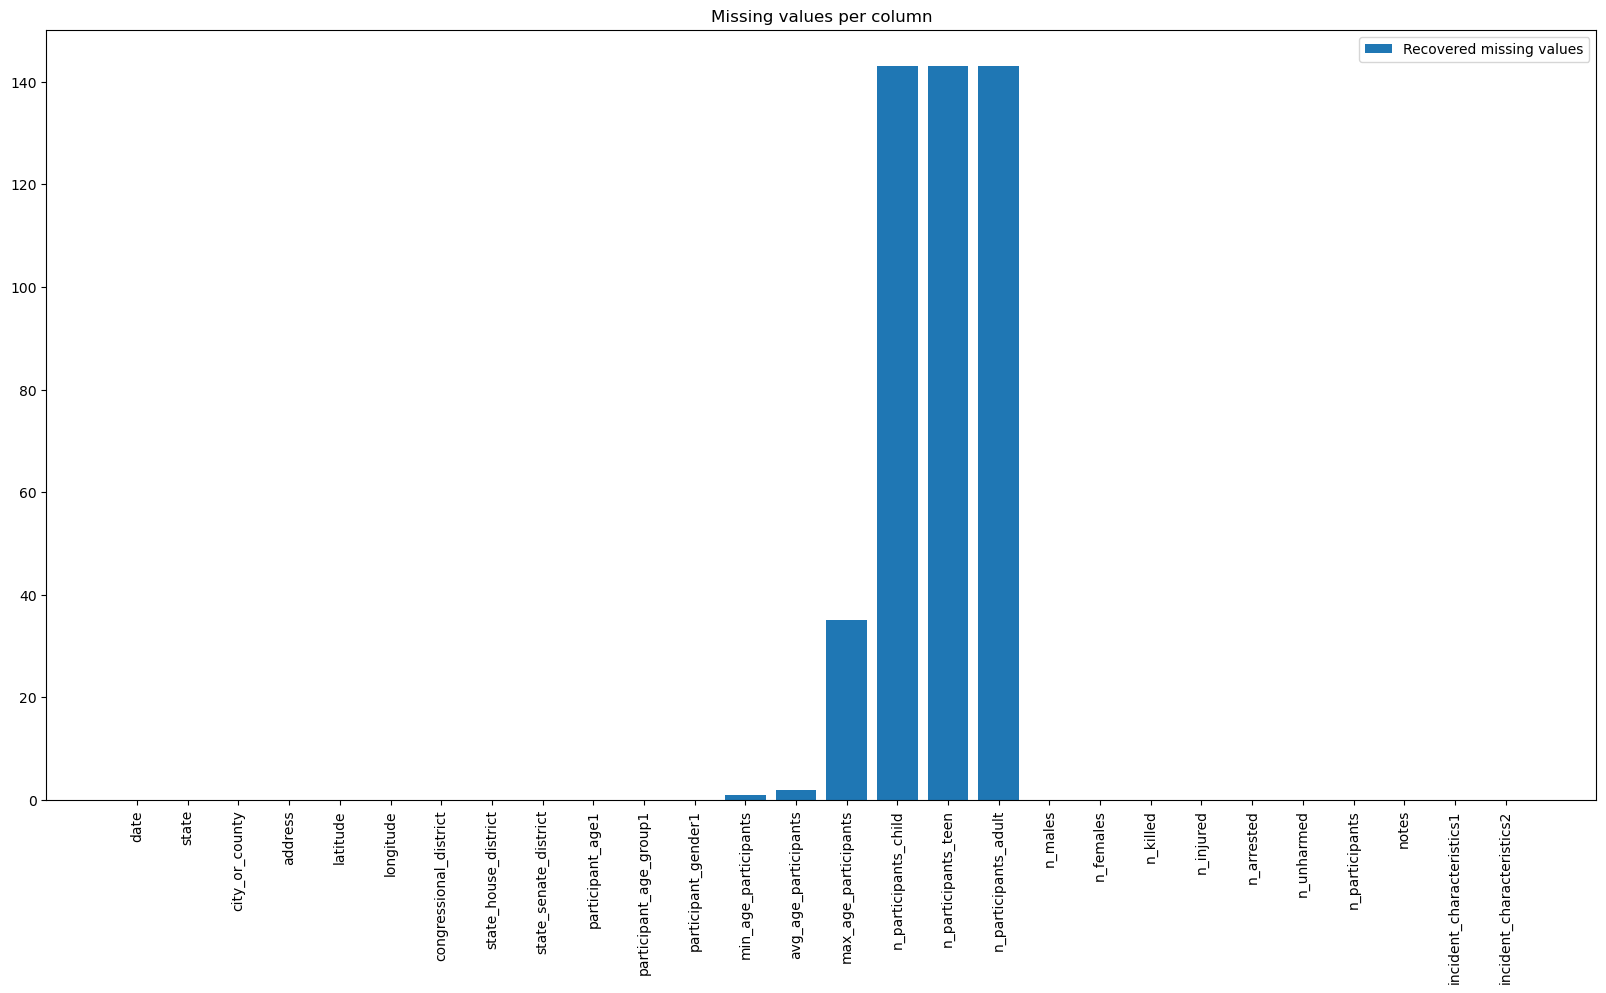

In [12]:
nullFillTab1 = tab1.isnull().sum()
plt.figure(figsize=(20,10))
plt.bar(tab1.columns, cleaningTab1-nullFillTab1, label='Recovered missing values')
plt.title('Missing values per column')
plt.legend()
plt.xticks(rotation=90)
plt.show()

## Cleaning poverty

In [13]:
def povertyImprovment(povertyByStateYear_path: str = f'{DATA_PATH}/povertyByStateYear.csv') -> pd.DataFrame: 
    """
    Gestisce valori sbagliati, nulli e mancanti del dataset povertyByStateYear.csv e ritorna il dataframe risultante.
    
    Il datafreame povertyByStateYear:
        - contiene valori null per il campo 2012 => calcola la media tra 2011 e 2013 in base allo stato
        - coppia <Wyoming, 2009> compare due volte con valori diversi per povertyPercentage => sostituisci con la media
        - coppia <Wyoming, 2010> non compare => aggiungi una riga con la media tra 2009 e 2011
    Per riempire questi valori nulli, si è deciso di calcolare la media tra i valori del campo 2011 e 2013 in baso allo stato.
    """
    
    poverty_dtype={
            'state': 'string',
            'year': 'int64',
            'povertyPercentage': 'float64'
    }

    df = pd.read_csv(povertyByStateYear_path, sep=',', dtype=poverty_dtype)
    
    #coppia <Wyoming, 2009> compare due volte con valori diversi per povertyPercentage => sostituisci con la media
    mean_value = df[(df.state == "Wyoming") & (df.year == 2009)].povertyPercentage.mean()
    df.drop_duplicates(inplace=True, subset=['state', 'year'])
    df.loc[(df.state == "Wyoming") & (df.year == 2009), 'povertyPercentage'] = mean_value
    
    
    #Coppia <Wyoming, 2010> non compare => aggiungi una riga con la media tra 2009 e 2011
    povertyPercentage_2009 = df[(df.state == "Wyoming") & (df.year == 2009)].povertyPercentage.values[0]
    povertyPercentage_2011 = df[(df.state == "Wyoming") & (df.year == 2011)].povertyPercentage.values[0]
    mean_povertyPercentage = (povertyPercentage_2009 + povertyPercentage_2011) / 2

    new_entry = pd.DataFrame({'state': ['Wyoming'], 'year': [2010], 'povertyPercentage': [mean_povertyPercentage]})
    df = pd.concat([df, new_entry], ignore_index=True)
    
    
    #Il campo 2012 è vuoto => calcola la media tra 2011 e 2013 in base allo stato
    df_2013 = df[df['year'] == 2013]
    df_2011 = df[df['year'] == 2011]

    #Calcola media povertyPercentage tra 2013 e 2011 in base allo stato
    merged = pd.merge(df_2013, df_2011, on='state', suffixes=('_2013', '_2011')).drop(columns=['year_2013', 'year_2011'])
    merged['povertyPercentage_2012'] = (merged['povertyPercentage_2013'] + merged['povertyPercentage_2011']) / 2
    merged = merged.drop(columns=['povertyPercentage_2013', 'povertyPercentage_2011'])

    #Sostiuisci i valori dell'anno 2012 con la media calcolata (NB tutti i valori )
    merge_df = pd.merge(df, merged, on="state", how="left", suffixes=('', '_2012'))
    merge_df['povertyPercentage'] = merge_df['povertyPercentage'].fillna(merge_df['povertyPercentage_2012'])
    
    return merge_df.drop(columns=['povertyPercentage_2012'])

tab2=povertyImprovment()

## Cleaning state

In [14]:
def yearStateDistrictHouseImpr(yearStateDistrictHouse_path: str = f'{DATA_PATH}/year_state_district_house.csv') -> pd.DataFrame:
   
    state_dtype={
        'state': 'string',
        'party': 'string'
    }

    df = pd.read_csv(yearStateDistrictHouse_path, sep=',', low_memory=False, dtype=state_dtype)
    df.loc[tab3['candidatevotes'] == -1, ['candidatevotes']] = np.nan
    df.loc[tab3['totalvotes'] == -1, ['totalvotes']] = np.nan
    df.loc[tab3['candidatevotes'] == 0, ['candidatevotes']] = np.nan
    df.loc[tab3['totalvotes'] == 0, ['totalvotes']] = np.nan
    df=df.replace('FOGLIETTA (DEMOCRAT)', 'INDEPENDENT')
    return df

tab3 = yearStateDistrictHouseImpr()

## Merge
left join dei file yearState e poverty su incidents. In questo modo si perdono i record con attributo year superiore al 2018

In [15]:
# tab1=tab1.drop(columns= ["city_or_county","address","state_house_district","state_senate_district","incident_characteristics2"])
tab1['year'] = tab1['date'].dt.year
tab = pd.merge(tab1, tab2, on=['year', 'state'], how='left')

tab3['state'] = tab3['state'].str.title()
tab = pd.merge(tab, tab3, on=["year","state","congressional_district"],how="left").drop(columns=["year"])

In [16]:
tab.isnull().sum()

date                          23261
state                             0
city_or_county                    0
address                       16447
latitude                       7923
longitude                      7923
congressional_district        11943
state_house_district          38733
state_senate_district         32306
participant_age1              92061
participant_age_group1        41907
participant_gender1           36115
min_age_participants          92050
avg_age_participants          92022
max_age_participants          93448
n_participants_child          62550
n_participants_teen           62550
n_participants_adult          62596
n_males                       43286
n_females                     43286
n_killed                          0
n_injured                         0
n_arrested                    27393
n_unharmed                    27393
n_participants                26584
notes                         80823
incident_characteristics1       326
incident_characteristics2   

### Rimozione delle entry con troppi valori null

La seguente cella resituisce la percentuale di righe che hanno x="Numero di valori null per riga" (e.g. il 49.9% delle righce contengono almeno 3 valori null)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


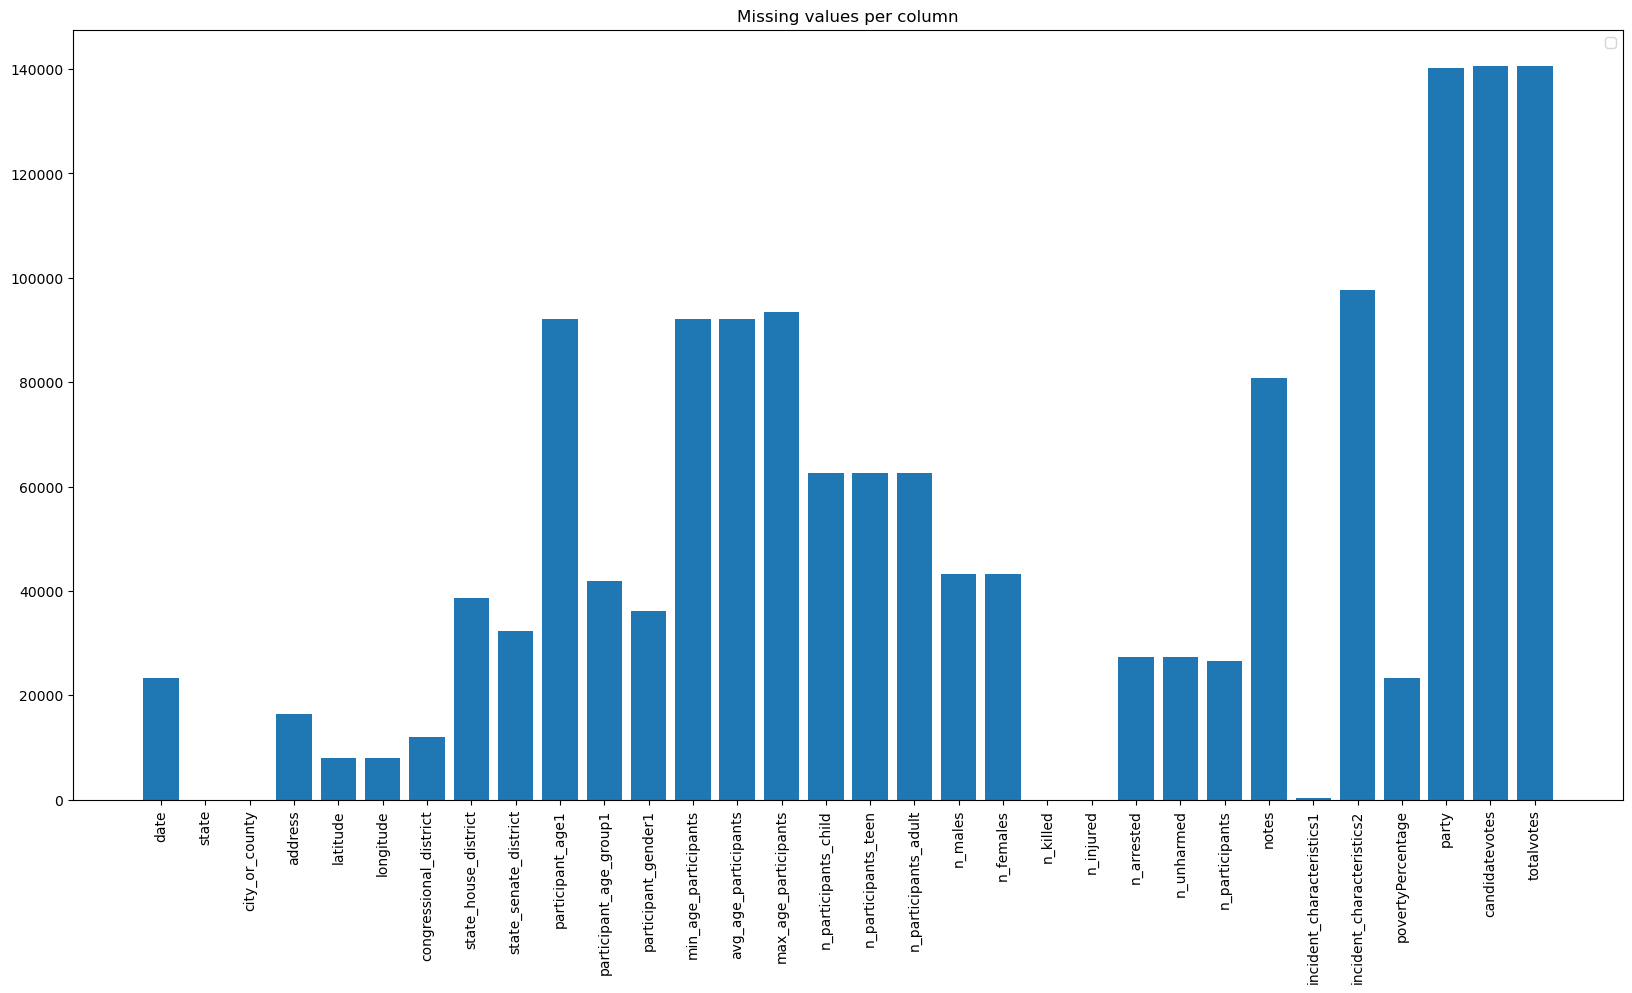

In [17]:
plt.figure(figsize=(20,10))
plt.bar(tab.columns, tab.isnull().sum())
plt.title('Missing values per column')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [18]:
def count_null_entries(df, ignore=[]):
    """
    
    """
    null_counts = df.drop(ignore, axis=1).isnull().sum(axis=1)
    null_percentage = null_counts.value_counts().sort_index()/len(df)*100
    return null_percentage.reset_index().rename(columns={'index': 'Numero di valori null per riga', 'count': 'Percentuale righe null'})

# La maggior parte dei valori party', 'candidatevotes', 'totalvotes sono nulli (questo perché le elezioni avvengono ogni due anni)
ignore = ['city_or_county', 'address', 'state_house_district', 'state_senate_district', 'notes', 'incident_characteristics1', 'incident_characteristics2', 'party', 'candidatevotes', 'totalvotes']
count_null_entries(tab, ignore)

,Numero di valori null per riga,Percentuale righe null
0,0,49.988930
1,1,0.830893
2,2,0.207201
3,3,4.098070
4,4,13.840697
5,5,0.339208
6,6,7.889933
7,7,2.380306
8,8,4.194151
9,9,0.577322


Text(0, 0.5, 'percentuale di record')

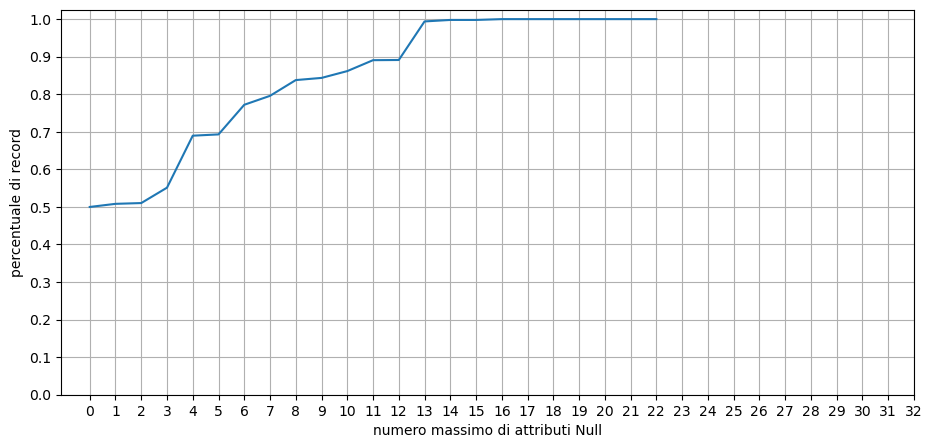

In [19]:
def get_null_entries(df, ignore=[]):
    temp={}
    df = df.drop(ignore, axis=1)
    for threshold in range(0,(len(df.columns)+1),1):
        mask= (df.isnull().sum(axis=1)) <= threshold
        temp[threshold]=(mask.sum()/len(df))
    return temp

temp = get_null_entries(tab, ignore)
fig, ax= plt.subplots(figsize=(11,5))
ax.plot(temp.keys(),temp.values())
ax.set_xticks(range(0,len(tab.columns)+1,1))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.grid()
ax.set_xlabel("numero massimo di attributi Null")
ax.set_ylabel("percentuale di record")

#### Dal grafico si deduce che togliendo tutte le entry con più di 8 missing value, rimarrebbero l'80% delle entry, inoltre il 25% delle entry è sprovvisto di missing value

Rimozione righe con troppi valori null

In [20]:
def drop_rows_with_nulls(df, threshold, ignore_cols=[]):
    """
    threshold: numero massimo di attributi null per riga (e.g. se threshold=2 => vengono eliminate le righe con più di due valori null)
    Attributi in ignore_cols non vengono considerati nel conteggio.
    """
    df = df.drop(ignore, axis=1)
    df = df.dropna(thresh=df.shape[1]-threshold, subset=[col for col in df.columns if col not in ignore_cols])
    return df
tab = drop_rows_with_nulls(tab, threshold=14, ignore_cols=ignore) #TODO valore messo a caso per controllare il corretto funzionamento del codice

## Output nuova tabella

In [21]:
tab.to_csv(f"{DATA_PATH}/cleaned_data.csv", index=False)